In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

**Loading the dataset**

In [4]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, phase, transform):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        self.image_paths = []
        self.clean_paths = []
        self.mask_paths = []

        # Iterate through all classes in the root directory
        self.classes = os.listdir(root_dir)
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            phase_dir = os.path.join(class_path, self.phase)

            # Check if phase_dir exists
            if os.path.exists(phase_dir):
                print(f"Processing class: {class_name} in {phase_dir}")  # Debugging statement
                
                for folder_type in ['Defect_mask', 'Degraded_image', 'GT_clean_image']:
                    self._load_images_for_folder_type(phase_dir, folder_type)

    def _load_images_for_folder_type(self, phase_dir, folder_type):
        folder_path = os.path.join(phase_dir, folder_type)
        print(f"Looking for folder: {folder_path}")  # Debugging statement

        # Ensure the folder exists before loading
        if os.path.exists(folder_path):
            for defect_type in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, defect_type)
                print(f"Checking subfolder: {subfolder_path}")  # Debugging statement

                # Ensure subfolder exists
                if os.path.isdir(subfolder_path):
                    for image_name in os.listdir(subfolder_path):
                        image_path = os.path.join(subfolder_path, image_name)

                        # Append paths based on the folder type
                        if folder_type == 'Degraded_image':
                            self.image_paths.append(image_path)
                        elif folder_type == 'GT_clean_image':
                            self.clean_paths.append(image_path)
                        elif folder_type == 'Defect_mask':
                            self.mask_paths.append(image_path)

                    # Print how many images were loaded from each subfolder
                    print(f"Loaded {len(os.listdir(subfolder_path))} images from {subfolder_path}")
                              #Ensure all paths are loaded consistently
                    print(f"Loaded {len(self.image_paths)} degraded images, {len(self.clean_paths)} clean images, {len(self.mask_paths)} masks from {folder_type}.")
        else:
            print(f"Folder does not exist: {folder_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load images using PIL
        degraded_image = Image.open(self.image_paths[idx]).convert('RGB')
        clean_image = Image.open(self.clean_paths[idx]).convert('RGB')
        mask_image = Image.open(self.mask_paths[idx])  # Grayscale mask

        # Apply any transformations if specified
        if self.transform:
            degraded_image = self.transform(degraded_image)
            clean_image = self.transform(clean_image)
            mask_image = self.transform(mask_image)

        return degraded_image, clean_image, mask_image


In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
dataset_path = '/home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val'

In [7]:
test_dataset = MVTecDataset(root_dir=dataset_path, phase='Val', transform=transform)  #For time being keeping phase ='Val' need to change to 'Test' at time of evaluation

Processing class: grid in /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val
Looking for folder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 0 degraded images, 0 clean images, 1 masks from Defect_mask.
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 0 degraded images, 0 clean images, 2 masks from Defect_mask.
Checking subfolder: /home/user/Downloa

In [8]:
print(f"Total number of degraded images: {len(test_dataset.image_paths)}")
print(f"Total number of clean images: {len(test_dataset.clean_paths)}")
print(f"Total number of defect masks: {len(test_dataset.mask_paths)}")

Total number of degraded images: 88
Total number of clean images: 88
Total number of defect masks: 88


In [9]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Displaying sample images

In [10]:

degraded_img, clean_img, mask_img = test_dataset[0]  # Access the first sample


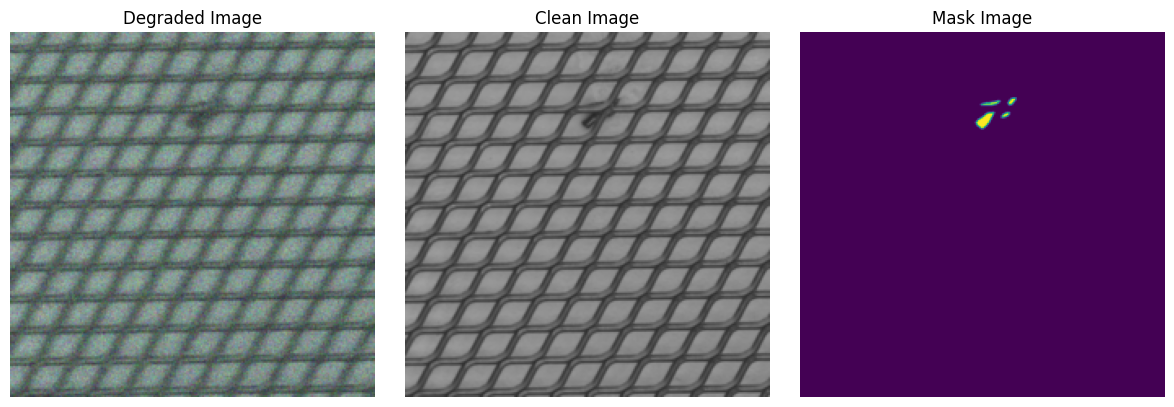

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose images if needed (assuming they are (3, 224, 224))
degraded_img = np.transpose(degraded_img, (1, 2, 0))
clean_img = np.transpose(clean_img, (1, 2, 0))
mask_img = np.transpose(mask_img, (1, 2, 0))

# Set up a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot each image in a separate subplot
axs[0].imshow(degraded_img)
axs[0].axis('off')
axs[0].set_title('Degraded Image')

axs[1].imshow(clean_img)
axs[1].axis('off')
axs[1].set_title('Clean Image')

axs[2].imshow(mask_img)
axs[2].axis('off')
axs[2].set_title('Mask Image')

plt.tight_layout()  # Optional: adjusts spacing between plots for a cleaner look
plt.show()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
import skimage.metrics
import numpy as np

def calculate_metrics(original, restored):
    # Ensure images are in float32 format
    original = original.astype(np.float32)
    restored = restored.astype(np.float32)

    # Ensure the images are in the expected range
    original = np.clip(original, 0, 1)
    restored = np.clip(restored, 0, 1)

    # Calculate PSNR
    psnr_value = skimage.metrics.peak_signal_noise_ratio(original, restored, data_range=1.0)

    # Debugging: Print shapes and dtypes
    print(f"Original shape: {original.shape}, Restored shape: {restored.shape}")
    print(f"Original dtype: {original.dtype}, Restored dtype: {restored.dtype}")

    # Dynamically adjust win_size for SSIM
    min_dim = min(original.shape[:2])  # Get the smallest dimension
    win_size = min(11, min_dim) if min_dim % 2 == 1 else min(11, min_dim - 1)

    # Calculate SSIM with appropriate parameters
    ssim_value = skimage.metrics.structural_similarity(
        original,
        restored,
        data_range=1.0,
        win_size=win_size,
        channel_axis=-1  # Set to -1 if channels are in the last dimension
    )
    
    return psnr_value, ssim_value


**Autoencoder Model**

In [14]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (N, 3, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (N, 64, H, W) -> (N, 128, H, W)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (N, 128, H, W) -> (N, 256, H/2, W/2)
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 256, H/2, W/2) -> (N, 128, H, W)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # (N, 128, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (N, 64, H, W) -> (N, 3, H, W)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


**Loading the model**

In [15]:
#Loading the model
#Loading from the entire model
# Load the entire model
model_AE = torch.load('ae_model_full.pth')
model_AE = model_AE.to(device)  # Move to the appropriate device
#model_AE.eval()  # Set to evaluation mode for inference


/tmp/ipykernel_2563242/3174936428.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE = torch.load('ae_model_full.pth')


Loading the model weights

In [16]:
#Loading from only the weights
# Initialize the model (redefine architecture)
model_AE = Autoencoder().to(device)

# Load the state dictionary (weights)
model_AE.load_state_dict(torch.load('ae_model_weights.pth'))

# Set to evaluation mode for inference
#model_AE.eval()



/tmp/ipykernel_2563242/3505085576.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE.load_state_dict(torch.load('ae_model_weights.pth'))


<All keys matched successfully>

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 24.866402316716993, SSIM: 0.7062033414840698


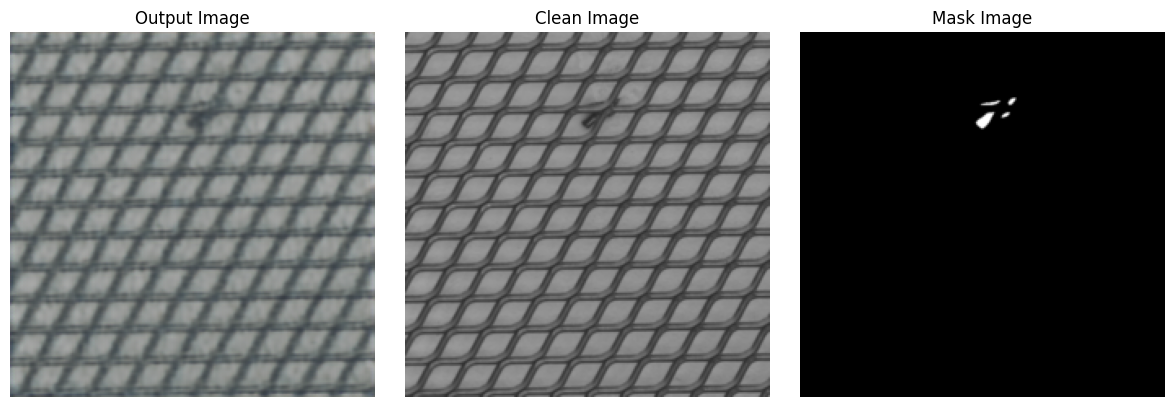

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.3399707106222, SSIM: 0.6866984963417053
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 24.4457175629829, SSIM: 0.6778573989868164
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 24.585823006499833, SSIM: 0.7873867154121399
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.96779025592581, SS

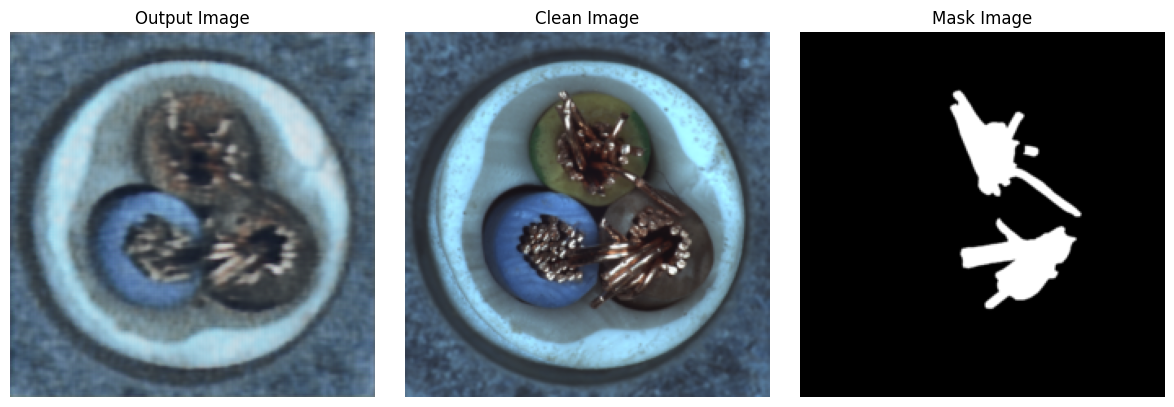

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.552915465189386, SSIM: 0.8759333491325378
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.56732185200045, SSIM: 0.7906786203384399
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.114661166544764, SSIM: 0.6856547594070435
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.7423100638014, 

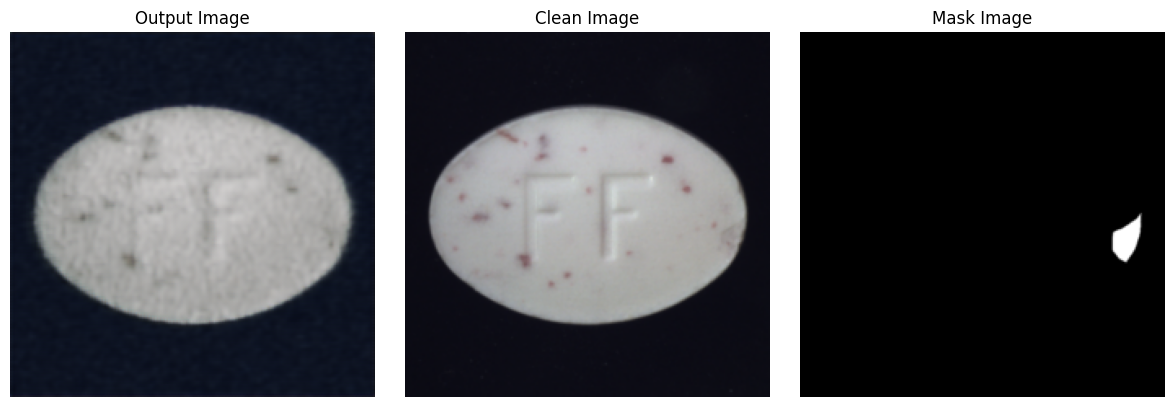

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.766996710198455, SSIM: 0.8958247303962708
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.55132657705427, SSIM: 0.8565216064453125
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 30.316468863861203, SSIM: 0.9087395071983337
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.180732445933344

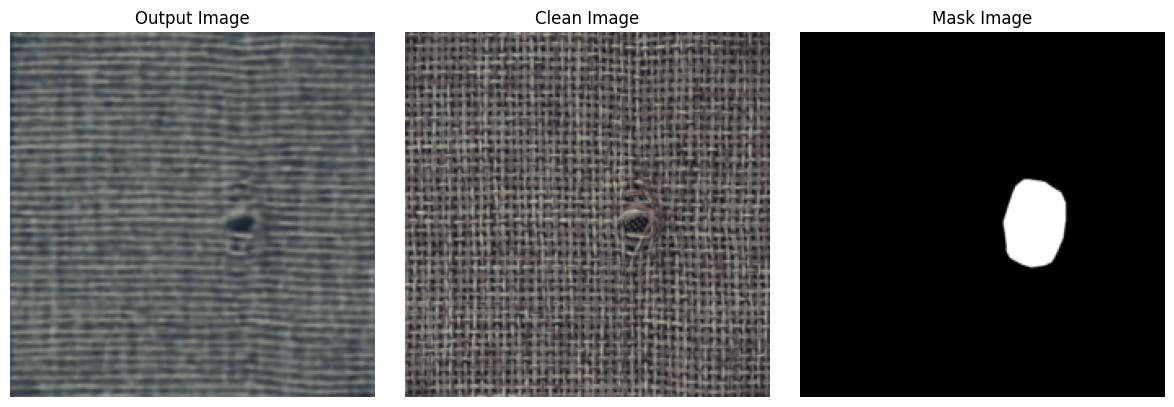

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 21.838040254409428, SSIM: 0.6686918139457703
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.105203451477657, SSIM: 0.7130969762802124
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 21.40226948637482, SSIM: 0.7324833869934082
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 21.213311813927973

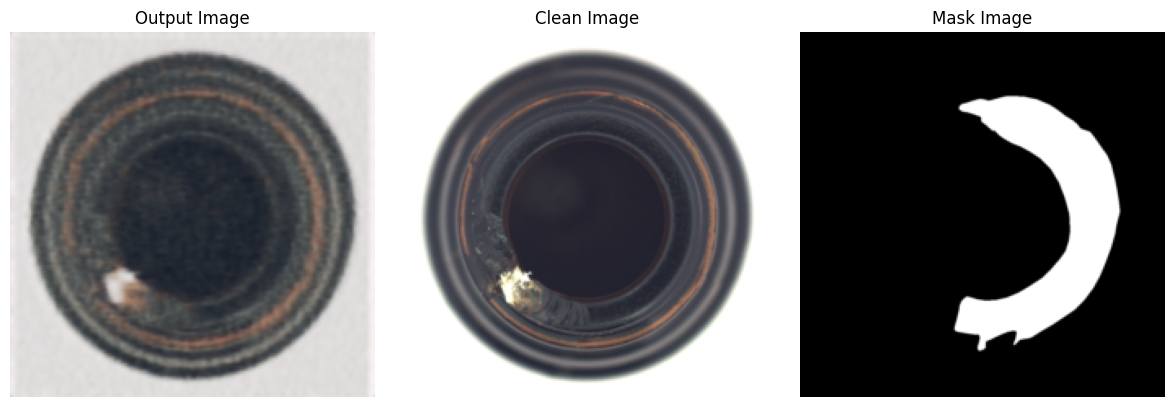

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.852387269505172, SSIM: 0.8548277616500854
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.796651989316576, SSIM: 0.8458644151687622
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.286381232702873, SSIM: 0.8396815061569214
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.17617240055672

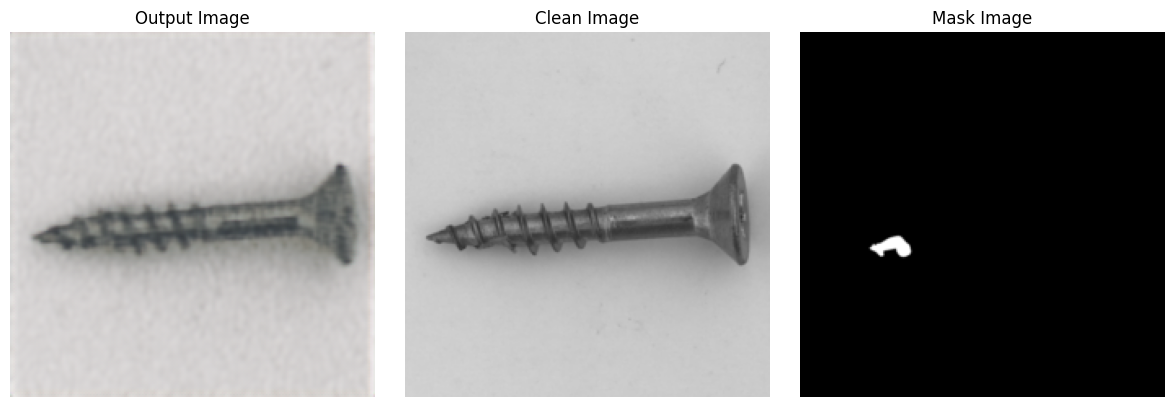

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 33.08244106904607, SSIM: 0.9297686219215393
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 30.718927235762585, SSIM: 0.9065860509872437
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.791424664503488, SSIM: 0.8742609024047852
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.91427135289938,

In [17]:
# Load test or validation dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  #Currently given bathc_size = 1

psnr_values = []
ssim_values = []

with torch.no_grad():
    for degraded, clean, mask in test_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        # Loop through each image in the batch
        for i in range(output_images.shape[0]):
            output_image = output_images[i].squeeze()
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()

            # Check image shapes before calculating metrics
            print(f'Clean image shape: {clean_image.shape}')
            print(f'Output image shape: {output_image.shape}')
            print(f'Mask image shape: {mask_image.shape}')

            # Calculate metrics for each image
            psnr, ssim = calculate_metrics(clean_image, output_image)
            print(f'PSNR: {psnr}, SSIM: {ssim}')

            if i==0:  #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github

                # Transpose if necessary for visualization
                output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
                clean_img = np.transpose(clean_image, (1, 2, 0)) if clean_image.ndim == 3 else clean_image
                mask_img = np.transpose(mask_image, (1, 2, 0)) if mask_image.ndim == 3 else mask_image

                # Set up a figure with 1 row and 3 columns
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                # Plot each image in a separate subplot
                axs[0].imshow(output_img)
                axs[0].axis('off')
                axs[0].set_title('Output Image')

                axs[1].imshow(clean_img)
                axs[1].axis('off')
                axs[1].set_title('Clean Image')

                axs[2].imshow(mask_img, cmap='gray')
                axs[2].axis('off')
                axs[2].set_title('Mask Image')

                plt.tight_layout()
                plt.show()

            psnr_values.append(psnr)
            ssim_values.append(ssim)

    # Calculate average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

# Print average values
print(f"Average PSNR for the entire test set: {average_psnr:.2f}")
print(f"Average SSIM for the entire test set: {average_ssim:.2f}")


Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.78252615176863, Defect SSIM: 0.998936116695404


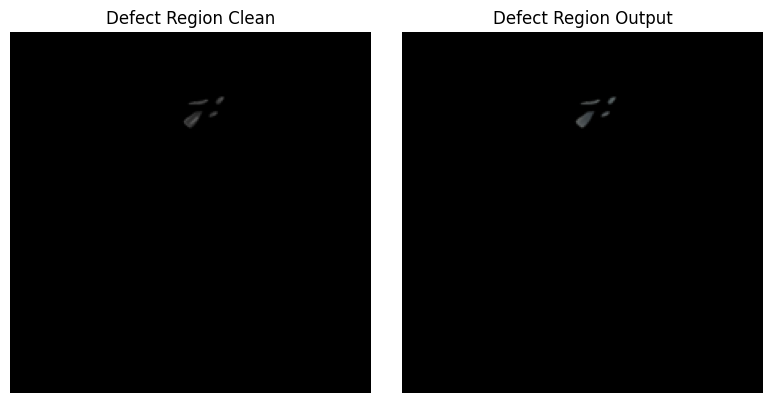

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.25866156518394, Defect SSIM: 0.9982784390449524
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.893305891484474, Defect SSIM: 0.9992360472679138
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.678249326733635, Defect SSIM: 0.9940387606620789
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.781434916955405, Defect SSIM: 0.9989592432975769
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.22561929213993, Defect SSIM: 0.996655285358429
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.59

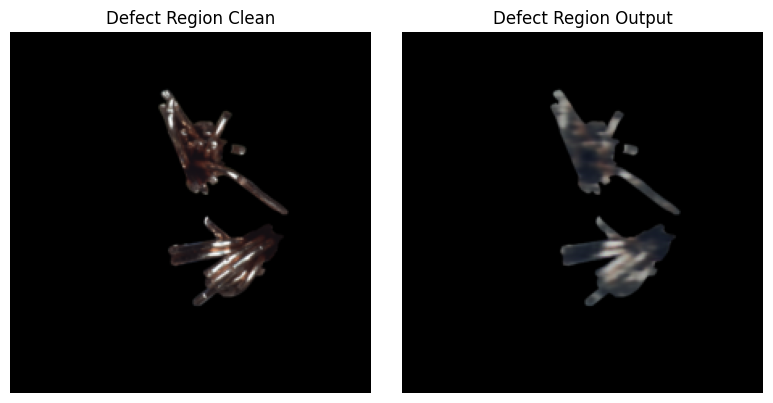

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.068367231172324, Defect SSIM: 0.9966438412666321
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 36.701407617024984, Defect SSIM: 0.9864745736122131
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 37.98584708436077, Defect SSIM: 0.97975754737854
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.38883882974066, Defect SSIM: 0.9986734390258789
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.0583734970075, Defect SSIM: 0.9944831728935242
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 28.57809

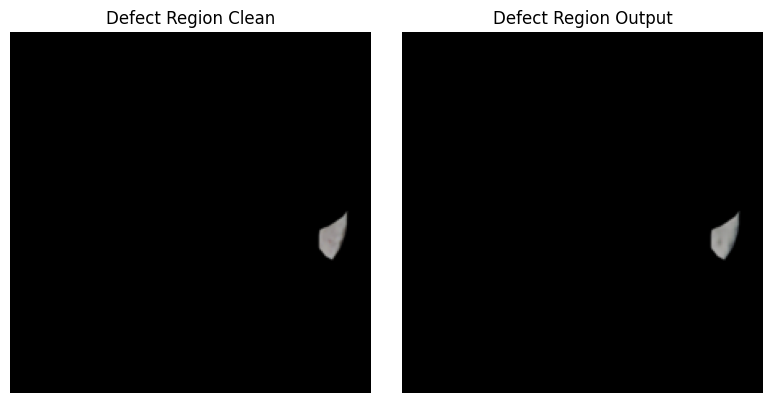

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.81328105516972, Defect SSIM: 0.998691976070404
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.63047924247237, Defect SSIM: 0.9994842410087585
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.295278028137254, Defect SSIM: 0.9986012578010559
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 29.32868492847526, Defect SSIM: 0.8716790676116943
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.956893989773945, Defect SSIM: 0.9990108609199524
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 54.674

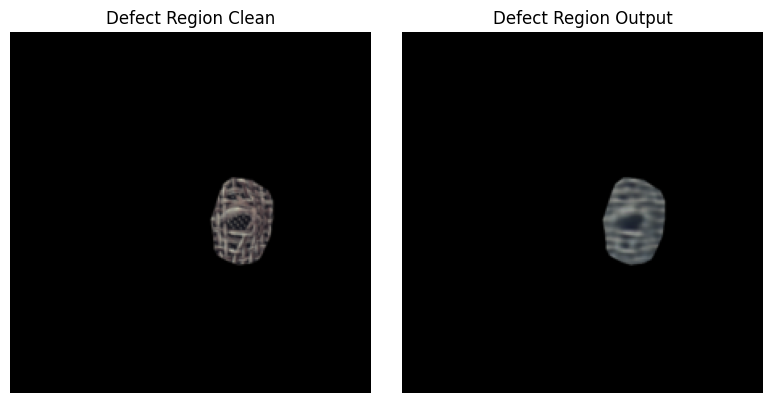

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.50015137306532, Defect SSIM: 0.9984198212623596
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 47.70466542789543, Defect SSIM: 0.9996545314788818
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.41872595122034, Defect SSIM: 0.9991608262062073
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 34.4500528801822, Defect SSIM: 0.9832093715667725
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.71712440258402, Defect SSIM: 0.9988688826560974
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.92604

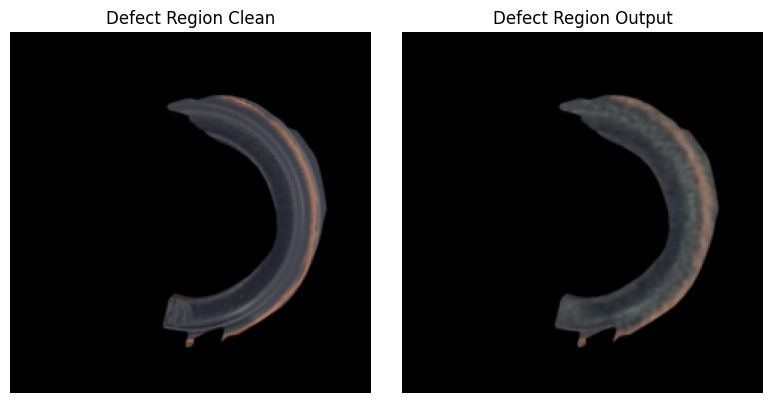

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.38700926831117, Defect SSIM: 0.991675615310669
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.11616051078166, Defect SSIM: 0.9975855350494385
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.094557527138065, Defect SSIM: 0.9993310570716858
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.40172398780577, Defect SSIM: 0.9991915822029114
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.23594276254143, Defect SSIM: 0.9975979328155518
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 37.6820

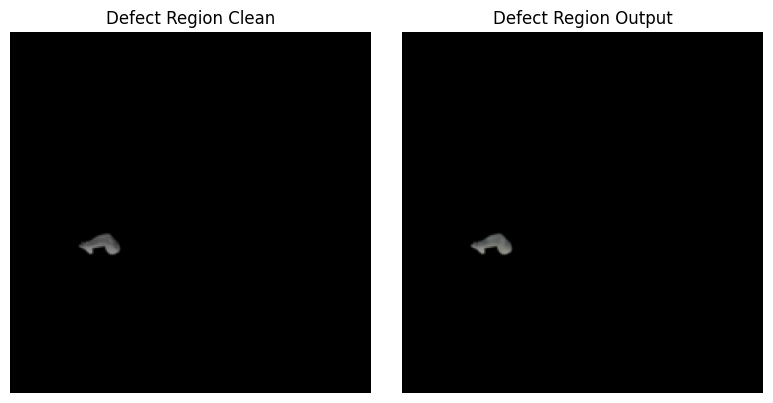

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 54.85357824150374, Defect SSIM: 0.9999380111694336
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 52.89398434018885, Defect SSIM: 0.999924898147583
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 39.66461177289767, Defect SSIM: 0.9953017234802246
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 32.233646270916, Defect SSIM: 0.9757025837898254
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.03199288231941, Defect SSIM: 0.9957553744316101
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 31.6759067

In [ ]:
import matplotlib.pyplot as plt

psnr_values_defect = []
ssim_values_defect = []

with torch.no_grad():
    for degraded, clean, mask in test_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays while keeping the batch dimension
        output_images = outputs.cpu().numpy()  # Shape: (batch_size, C, H, W)
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):  # Loop over each image in the batch
            output_image = output_images[i]  # Shape: (C, H, W)
            clean_image = clean_images[i]
            mask_image = mask_images[i]

            # Isolate defect regions using the mask
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image

            # Transpose for displaying with matplotlib
            defect_region_output = np.transpose(defect_region_output, (1, 2, 0))  # (H, W, C)
            defect_region_clean = np.transpose(defect_region_clean, (1, 2, 0))

            # Calculate PSNR and SSIM over defect regions only
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)
            print(f'Defect PSNR: {psnr_defect}, Defect SSIM: {ssim_defect}')


            if i == 0: #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github
                # Display defect regions
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(defect_region_clean)
                axs[0].axis('off')
                axs[0].set_title('Defect Region Clean')

                axs[1].imshow(defect_region_output)
                axs[1].axis('off')
                axs[1].set_title('Defect Region Output')

                plt.tight_layout()
                plt.show()

            # Append to lists
            psnr_values_defect.append(psnr_defect)
            ssim_values_defect.append(ssim_defect)

    # Calculate average defect PSNR and SSIM
    average_psnr_defect = np.mean(psnr_values_defect)
    average_ssim_defect = np.mean(ssim_values_defect)

# Print or save the defect-specific average PSNR and SSIM
print(f"Average PSNR for defect regions: {average_psnr_defect:.2f}")
print(f"Average SSIM for defect regions: {average_ssim_defect:.2f}")


In [31]:
import os
# from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Set up output folder
output_folder = "output_images_test"
os.makedirs(output_folder, exist_ok=True)

# Initialize lists to hold PSNR and SSIM values
psnr_values = []
ssim_values = []

# Initialize file for saving PSNR and SSIM metrics
metrics_file = os.path.join(output_folder, "metrics.txt")
with open(metrics_file, "w") as f:
    f.write("PSNR and SSIM values for each test image:\n\n")

# Set win_size based on the smallest dimension of your images
smallest_dimension = min(clean_image.shape[:2])
win_size = smallest_dimension if smallest_dimension % 2 == 1 else smallest_dimension - 1

with torch.no_grad():
    for idx, (degraded, clean, mask) in enumerate(test_loader):
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays
        output_image = outputs.cpu().numpy().squeeze()
        clean_image = clean.cpu().numpy().squeeze()
        mask_image = mask.cpu().numpy().squeeze()

        # Save output image to the folder
        output_path = os.path.join(output_folder, f"output_image_{idx}.png")
        plt.imsave(output_path, output_image if output_image.ndim == 2 else np.transpose(output_image, (1, 2, 0)))

        # Calculate PSNR and SSIM over the entire image and defect regions

        psnr_value, ssim_value = calculate_metrics(clean_image, output_image)
        
        # psnr_value = psnr(clean_image, output_image, data_range=clean_image.max() - clean_image.min())
        # ssim_value = ssim(clean_image, output_image, win_size=win_size, channel_axis=-1 if clean_image.ndim == 3 else None)

        psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)

        # psnr_defect = psnr(defect_region_clean, defect_region_output, data_range=clean_image.max() - clean_image.min())
        # ssim_defect = ssim(defect_region_clean, defect_region_output, win_size=win_size, channel_axis=-1 if defect_region_clean.ndim == 3 else None)

        # Append the metrics
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

        # Write metrics for each image to the file
        with open(metrics_file, "a") as f:
            f.write(f"Image {idx + 1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}\n")
            f.write(f"Defect Region: PSNR = {psnr_defect:.2f}, SSIM = {ssim_defect:.4f}\n\n")
    
    # Calculate and save average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

    # Write average metrics to the file
    with open(metrics_file, "a") as f:
        f.write("\nAverage PSNR and SSIM for the entire test set:\n")
        f.write(f"Average PSNR: {average_psnr:.2f}\n")
        f.write(f"Average SSIM: {average_ssim:.4f}\n")

# Print average values
print(f"Average PSNR for the entire validation set: {average_psnr:.2f}")
print(f"Average SSIM for the entire validation set: {average_ssim:.2f}")


Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original s